In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [7]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [8]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [9]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [10]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [11]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [12]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [13]:
x,y = next(iter(md.trn_dl))

In [14]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

## Simple upsample

In [15]:
f = resnet34
cut,lr_cut = model_meta[f]

In [16]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [17]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [18]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [19]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [20]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [21]:
m_base = get_base()

In [22]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [23]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [24]:
learn.freeze_to(1)

 89%|████████▉ | 57/64 [00:39<00:04,  1.45it/s, loss=1]    

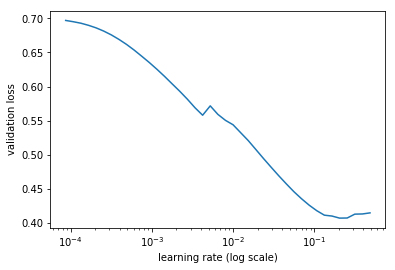

In [25]:
learn.lr_find()
learn.sched.plot()

In [26]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [27]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.120916   0.058532   0.973051   0.938873  
    1      0.060458   0.045353   0.977839   0.952048        
    2      0.041782   0.034096   0.983317   0.964571        
    3      0.033008   0.030686   0.984891   0.968326        


[array([0.03069]), 0.9848909519967579, 0.9683263950737659]

In [28]:
learn.save('tmp')

In [29]:
learn.load('tmp')

In [30]:
learn.unfreeze()
learn.bn_freeze(True)

In [31]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.028468   0.028486   0.988913   0.972487  
    1      0.0259     0.02583    0.989691   0.974962        
    2      0.023918   0.024385   0.989665   0.976466        
    3      0.022435   0.023178   0.990608   0.977892        


[array([0.02318]), 0.9906076088784233, 0.9778917411836644]

In [32]:
learn.save('128')

In [33]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

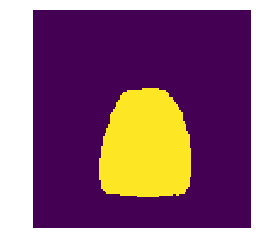

In [34]:
show_img(py[0]>0);

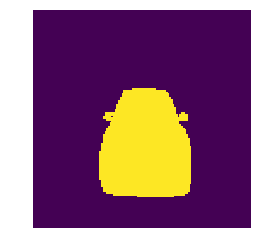

In [35]:
show_img(y[0]);

## U-net (ish)

In [36]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [37]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [38]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [39]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [40]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [41]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [42]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [43]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [44]:
learn.freeze_to(1)

 92%|█████████▏| 59/64 [00:36<00:03,  1.61it/s, loss=0.771]

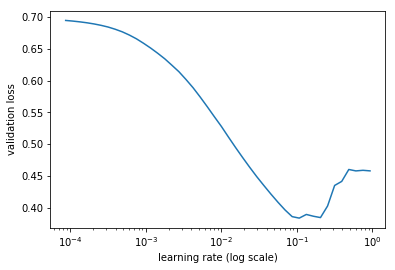

In [45]:
learn.lr_find()
learn.sched.plot()

In [46]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [47]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.062142   0.026161   0.988605   0.974293  
    1      0.03222    0.027716   0.988398   0.972889        
    2      0.024841   0.021678   0.990584   0.978729        
    3      0.021396   0.02003    0.992265   0.980805        
    4      0.019855   0.02237    0.992023   0.978722        
    5      0.018582   0.020968   0.990158   0.979161        
    6      0.017825   0.017998   0.99275    0.98282         
    7      0.016755   0.017647   0.992756   0.983091        


[array([0.01765]), 0.9927561320955791, 0.98309065027336]

In [48]:
learn.save('128urn-tmp')

In [49]:
learn.load('128urn-tmp')

In [50]:
learn.unfreeze()
learn.bn_freeze(True)

In [51]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.015459   0.017589   0.993296   0.983341  
    1      0.015729   0.018306   0.993163   0.982658        
    2      0.015272   0.016468   0.993039   0.984286        
    3      0.014953   0.016103   0.9936     0.984665        
    4      0.014593   0.01592    0.993153   0.984689        
    5      0.014158   0.015881   0.993418   0.984805        
    6      0.013855   0.015727   0.99336    0.984934        
    7      0.013634   0.015394   0.993604   0.985412        
    8      0.013425   0.015265   0.993818   0.985591        
    9      0.013282   0.015116   0.993726   0.9856          
    10     0.013124   0.015133   0.99392    0.985694        
    11     0.013053   0.015071   0.993887   0.985842        
    12     0.012818   0.015176   0.994066   0.985829        
    13     0.01266    0.014972   0.994102   0.985958        
    14     0.012557   0.014862   0.993911   0.986032        
    15     0.012428   0.014774

[array([0.01459]), 0.9941907619673108, 0.9863911263543378]

In [52]:
learn.save('128urn-0')

In [53]:
learn.load('128urn-0')

In [54]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

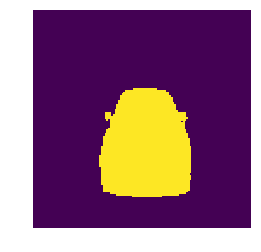

In [55]:
show_img(py[0]>0);

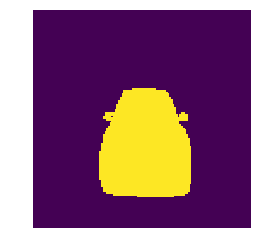

In [56]:
show_img(y[0]);

In [57]:
m.close()

## 512x512

In [58]:
sz=512
bs=16

In [59]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [60]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [61]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [62]:
learn.freeze_to(1)

In [63]:
learn.load('128urn-0')

In [64]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.009914   0.011365   0.996148   0.990469  
    1      0.007826   0.007813   0.996803   0.992769           
    2      0.007648   0.007938   0.996953   0.992747           
    3      0.006858   0.006738   0.997178   0.993676           
    4      0.006462   0.006598   0.997317   0.993803           


[array([0.0066]), 0.9973168070354159, 0.9938027709103816]

In [65]:
learn.save('512urn-tmp')

In [66]:
learn.unfreeze()
learn.bn_freeze(True)

In [67]:
learn.load('512urn-tmp')

In [68]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.006225   0.006822   0.997062   0.993656  
    1      0.005914   0.006131   0.997548   0.9943             
    2      0.065677   0.029404   0.989674   0.973893           
    3      0.015147   0.013775   0.994461   0.987698          
    4      0.011214   0.012041   0.995709   0.989469          
    5      0.010344   0.010457   0.996054   0.99071           
    6      0.009601   0.010009   0.996099   0.991013           
    7      0.009389   0.009708   0.996217   0.991297           


[array([0.00971]), 0.9962167058672223, 0.9912972941682725]

In [69]:
learn.save('512urn')

In [70]:
learn.load('512urn')

In [71]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

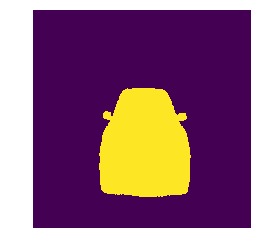

In [72]:
show_img(py[0]>0);

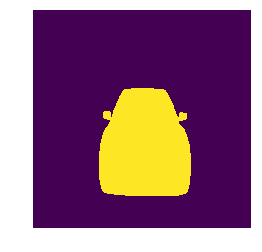

In [73]:
show_img(y[0]);

In [74]:
m.close()

## 1024x1024

In [ ]:
sz=1024
bs=4

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.load('512urn')

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

In [ ]:
learn.save('1024urn-tmp')

In [ ]:
learn.load('1024urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/200,lr/30,lr])

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('1024urn')

In [ ]:
learn.load('1024urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);